In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [195]:
# Load the dataset, skipping the first row
df = pd.read_csv("ILINet.csv", skiprows=1)

# Display the first few rows to check
print(df.head())
print(df.info())

  REGION TYPE REGION  YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI  AGE 0-4  \
0    National      X  1997    40         1.10148          1.21686      179   
1    National      X  1997    41         1.20007          1.28064      199   
2    National      X  1997    42         1.37876          1.23906      228   
3    National      X  1997    43         1.19920          1.14473      188   
4    National      X  1997    44         1.65618          1.26112      217   

  AGE 25-49 AGE 25-64  AGE 5-24 AGE 50-64  AGE 65  ILITOTAL  \
0         X       157       205         X      29       570   
1         X       151       242         X      23       615   
2         X       153       266         X      34       681   
3         X       193       236         X      36       653   
4         X       162       280         X      41       700   

   NUM. OF PROVIDERS  TOTAL PATIENTS  
0                192           46842  
1                191           48023  
2                219           5496

## Preprocessing

In [198]:
#Handling Categorical Variables
#'REGION TYPE'
#'REGION'
#convert to dummy variables in order to be used in a model
df = pd.get_dummies(df, columns=['REGION TYPE', 'REGION'], drop_first=True)

In [200]:
print(df.head())

   YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI  AGE 0-4 AGE 25-49 AGE 25-64  \
0  1997    40         1.10148          1.21686      179         X       157   
1  1997    41         1.20007          1.28064      199         X       151   
2  1997    42         1.37876          1.23906      228         X       153   
3  1997    43         1.19920          1.14473      188         X       193   
4  1997    44         1.65618          1.26112      217         X       162   

   AGE 5-24 AGE 50-64  AGE 65  ILITOTAL  NUM. OF PROVIDERS  TOTAL PATIENTS  
0       205         X      29       570                192           46842  
1       242         X      23       615                191           48023  
2       266         X      34       681                219           54961  
3       236         X      36       653                213           57044  
4       280         X      41       700                213           55506  


In [202]:
# Standardize Numeric Features
# Data has features on different scales -> percentages vs raw counts, need to scale
# Using StandardScaler to make sure all values have a zero mean and unit variance

# Convert problematic columns to numeric (replace 'X' with NaN and fill with median)
for col in ['AGE 25-49', 'AGE 25-64', 'AGE 50-64']:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert 'X' to NaN
    df[col] = df[col].fillna(df[col].median())  # Replace NaNs with median value

# Identify numeric columns again after cleaning
numeric_cols = ['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 
                'AGE 25-64', 'AGE 5-24', 'AGE 50-64', 'AGE 65', 'ILITOTAL', 
                'NUM. OF PROVIDERS', 'TOTAL PATIENTS']

# Standardize numeric features
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [204]:
print(df.head())

   YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI   AGE 0-4  AGE 25-49  \
0  1997    40       -0.542828        -0.444555 -0.745622  -0.284656   
1  1997    41       -0.476397        -0.399487 -0.742095  -0.284656   
2  1997    42       -0.355993        -0.428868 -0.736981  -0.284656   
3  1997    43       -0.476983        -0.495523 -0.744035  -0.284656   
4  1997    44       -0.169063        -0.413280 -0.738920  -0.284656   

   AGE 25-64  AGE 5-24  AGE 50-64    AGE 65  ILITOTAL  NUM. OF PROVIDERS  \
0  -0.693968 -0.653795  -0.273357 -0.514437 -0.646937          -1.295188   
1  -0.700287 -0.649881  -0.273357 -0.516591 -0.645309          -1.296069   
2  -0.698181 -0.647342  -0.273357 -0.512642 -0.642922          -1.271403   
3  -0.656057 -0.650515  -0.273357 -0.511925 -0.643935          -1.276689   
4  -0.688703 -0.645861  -0.273357 -0.510130 -0.642235          -1.276689   

   TOTAL PATIENTS  
0       -1.029240  
1       -1.027559  
2       -1.017683  
3       -1.014718  
4       -1.01690

## Training

In [207]:
# Train-test split chronologically

train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Features and target
X_train = train.drop(columns=['ILITOTAL', 'YEAR'])
y_train = train['ILITOTAL']
X_test = test.drop(columns=['ILITOTAL', 'YEAR'])
y_test = test['ILITOTAL']

In [209]:
# Incorporate time lags
# Create time lag from previous flu cases

df['lag_1'] = df['ILITOTAL'].shift(1)
df['lag_2'] = df['ILITOTAL'].shift(2)

# Drop missing values that result from lag creation
df = df.dropna()

In [211]:
# ARIMA Model

# Fit an ARIMA model (order of (p, d, q) needs to be tuned)
model = ARIMA(df['ILITOTAL'], order=(1, 1, 1))  # Example: AR(1), I(1), MA(1)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=10)  # Predicting the next 10 weeks
print(predictions)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1432    2.061479
1433    1.919547
1434    1.866680
1435    1.846988
1436    1.839653
1437    1.836921
1438    1.835904
1439    1.835525
1440    1.835383
1441    1.835331
Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Predicions are appearing stable over time. This could mean the the ARIMA Model is forecasting a steady state, possibly due to lack of trend or seasonal components in the data. ARIMA might not be capturing the seasonal trend or the parameters are not well suited for the data.

In [214]:
# Create a DateTime column combining the YEAR and WEEK

df['date'] = pd.to_datetime(df['YEAR'].astype(str) + df['WEEK'].astype(str).str.zfill(2) + '0', format='%Y%U%w')

# Set the 'date' as the index
df.set_index('date', inplace=True)

# Verify the new 'date' column and index
print(df.head())

            YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI   AGE 0-4  AGE 25-49  \
date                                                                           
1997-10-19  1997    42       -0.355993        -0.428868 -0.736981  -0.284656   
1997-10-26  1997    43       -0.476983        -0.495523 -0.744035  -0.284656   
1997-11-02  1997    44       -0.169063        -0.413280 -0.738920  -0.284656   
1997-11-09  1997    45       -0.332746        -0.397996 -0.745798  -0.284656   
1997-11-16  1997    46        0.053713        -0.282790 -0.725342  -0.284656   

            AGE 25-64  AGE 5-24  AGE 50-64    AGE 65  ILITOTAL  \
date                                                             
1997-10-19  -0.698181 -0.647342  -0.273357 -0.512642 -0.642922   
1997-10-26  -0.656057 -0.650515  -0.273357 -0.511925 -0.643935   
1997-11-02  -0.688703 -0.645861  -0.273357 -0.510130 -0.642235   
1997-11-09  -0.703446 -0.645755  -0.273357 -0.507617 -0.643862   
1997-11-16  -0.606561 -0.640784  -0.273357 

In [216]:
print(df.index)  # Should show the 'date' index
print(df.index.dtype)  # Should show 'datetime64[ns]'

DatetimeIndex(['1997-10-19', '1997-10-26', '1997-11-02', '1997-11-09',
               '1997-11-16', '1997-11-23', '1997-11-30', '1997-12-07',
               '1997-12-14', '1997-12-21',
               ...
               '2025-01-19', '2025-01-26', '2025-02-02', '2025-02-09',
               '2025-02-16', '2025-02-23', '2025-03-02', '2025-03-09',
               '2025-03-16', '2025-03-23'],
              dtype='datetime64[ns]', name='date', length=1432, freq=None)
datetime64[ns]


In [218]:
print(df.columns)

Index(['YEAR', 'WEEK', '% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4',
       'AGE 25-49', 'AGE 25-64', 'AGE 5-24', 'AGE 50-64', 'AGE 65', 'ILITOTAL',
       'NUM. OF PROVIDERS', 'TOTAL PATIENTS', 'lag_1', 'lag_2'],
      dtype='object')


In [220]:
print(df['ILITOTAL'].isna().sum())  # Should print 0 if there are no NaNs
print((df['ILITOTAL'] == float('inf')).sum())  # Should print 0 if there are no infinite values

0
0


In [222]:
print(df['ILITOTAL'].dtype)

float64


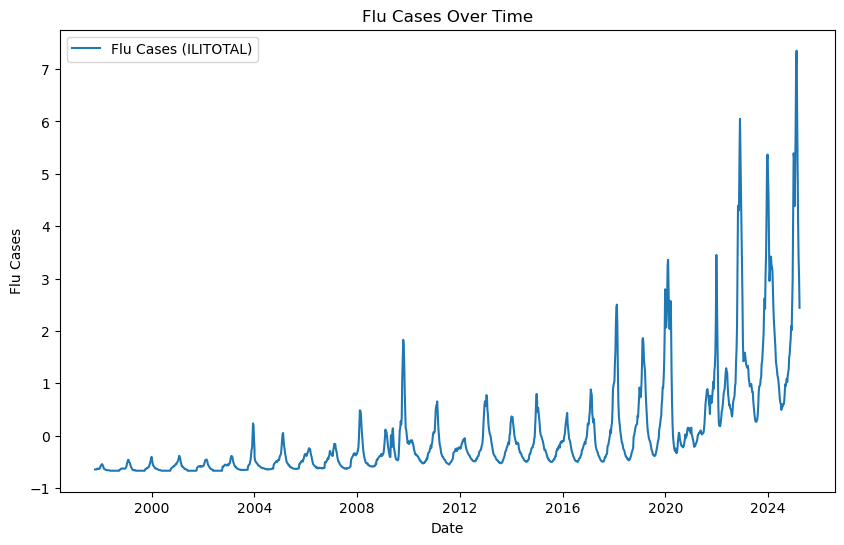

In [224]:
# Before refining the model, I wanted to see what the data looked like and understand the structure

# Plot the flu cases (ILITOTAL) over time
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['ILITOTAL'], label='Flu Cases (ILITOTAL)')
plt.xlabel('Date')
plt.ylabel('Flu Cases')
plt.title('Flu Cases Over Time')
plt.legend()
plt.show()

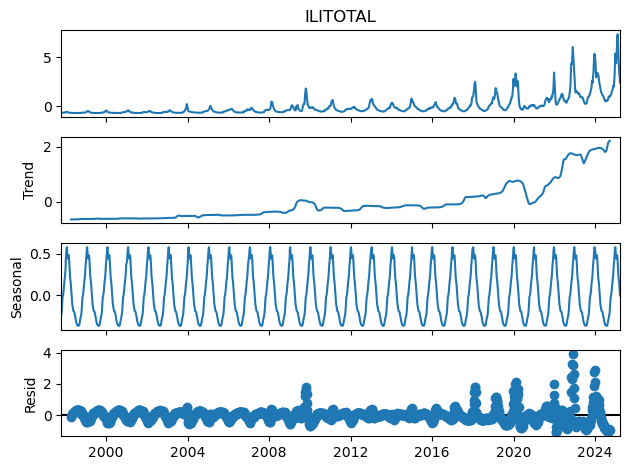

In [226]:
# Seasonal Decomposition

decomposition = seasonal_decompose(df['ILITOTAL'], model='additive', period=52)

# Plot the decomposition
decomposition.plot()
plt.show()

## Findings so far
- Observed and Trends are increasing:
- Flu cases are generally rising over time, could be an indication of long-term upward trend possibly due to populatio growth, changes in healthcare, or other factors.
- A SARMIA model would be good to handle the increasing trend.

- Seasonlity:
- Plot is suggesting yearly seasonablity which would make sense to incoporate seasonal patterns to flu cases.

- Residual:
- Data post 2020 shows significant deviations likely due to Covid, changes in healthcare, or social changes impacting flu rates.
- We have to examine these outliers more and we could use an ARIMA or SARIMA with external regressors to account for changes after 2020. 

### MODEL 1: SARIMA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.28866D-01    |proj g|=  1.12192D+00


 This problem is unconstrained.



At iterate    5    f= -4.49812D-01    |proj g|=  7.01999D-01

At iterate   10    f= -4.71917D-01    |proj g|=  6.36631D-01

At iterate   15    f= -4.83647D-01    |proj g|=  1.27064D-02
  ys=-2.555E-01  -gs= 1.783E-04 BFGS update SKIPPED

At iterate   20    f= -4.92759D-01    |proj g|=  3.71496D+00

At iterate   25    f= -4.92979D-01    |proj g|=  2.85250D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     54      1     1     0   2.853D-01  -4.930D-01
  F = -0.49297921057186583     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results         

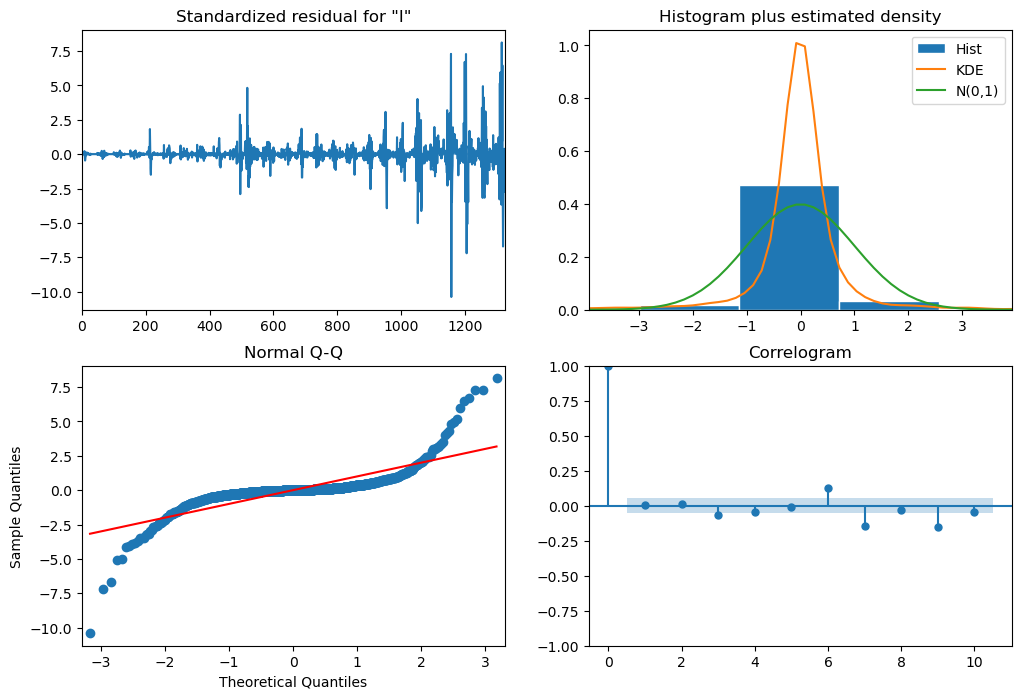

In [229]:
# SARIMA Modeling

sarima_model = SARIMAX(df['ILITOTAL'], 
                       order=(1, 1, 1),  # ARIMA(p, d, q)
                       seasonal_order=(1, 1, 1, 52),  # SARIMA(P, D, Q, s)
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Print the summary of the model
print(sarima_result.summary())

# Plot the diagnostics
sarima_result.plot_diagnostics(figsize=(12, 8))
plt.show()


### SARIMA Findings to note
- Log Likelihood: 705.946 - shows better model fit
- AIC: -1401.892 - lower values show better model fit
- BIC: -1375.947) - lower values show better model fit
- Coefficients:
-  AR Parameter: ar.L1 (0.3662) suggests a moderate positive relationship between previous period and current value
-  Seasonal AR: ar.S.L52 (-4.292e-06) is close to zero meaning the model does not rely on strong seasonal AR relationship. This could indicate that the seasonal component is not strongly impacting prediction

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


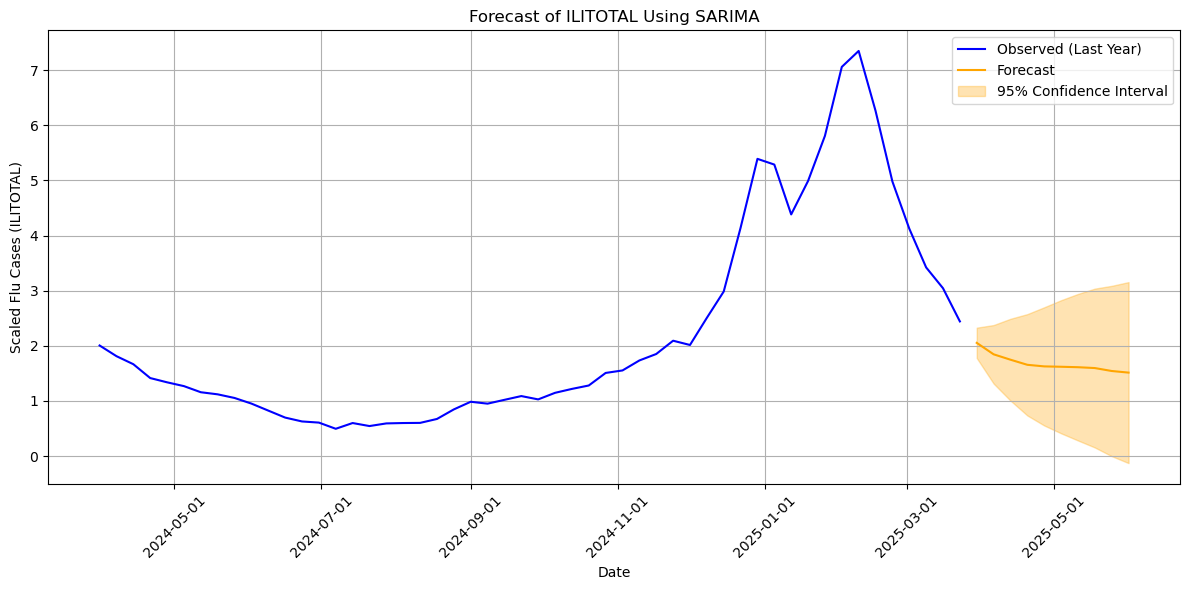

In [236]:
# Forecasting

plt.figure(figsize=(12, 6))

# Plot historical data (e.g., last 52 weeks for context)
plt.plot(df.index[-52:], df['ILITOTAL'].iloc[-52:], label='Observed (Last Year)', color='blue')

# Get forecasted values
forecast = sarima_result.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Generate forecast index
forecast_index = pd.date_range(start=df.index[-1], periods=11, freq='W')[1:]

# Plot forecast and CI
plt.plot(forecast_index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval'
)

# Formatting
plt.title('Forecast of ILITOTAL Using SARIMA')
plt.xlabel('Date')
plt.ylabel('Scaled Flu Cases (ILITOTAL)')
plt.legend()
plt.grid(True)

# Rotate and format date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## SARIMA Conclusions
- Extended the Observed Series (Blue): shows roughly the last year of data for context, and we can see the spike around late 2024 / early 2025 going above 7 on scaled ILITOTAL metric.
- Forecasting (Orange Line): The forecast starts right after last observed point (around late March 2025) and trends downward over the next several weeks, settling around 2 by early June. This makes sense since flu cases generally do drop as we exit winter months.
- Confidence Intervals (Orange Shaded Area): The 95% confidence interval widens over time, capturing the growing uncertainty as the forecast extends into the future.

- Seasonal behavior
- Visual Check: Historically, flu data often exhibits strong seasonality, typically peaking in the winter months.
- What the Plot Suggests: After a high peak around late winter/early spring, the model projects a decline, which could align with typical seasonal declines in flu activity.

- Peak Magnitude
- There is a large spike near the 7 on the y-axis, which is high comparatively. This can influene the model and we could investigate further why there was such a huge spike- more flu cases due to different variants or possibly Covid mistaken for flu. 

### MODEL 2: SARIMAX

In [242]:
# Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

df['exog_var'] = 1  # A constant exogenous variable

# Check the first few rows to confirm
print(df.head())

            YEAR  WEEK  % WEIGHTED ILI  %UNWEIGHTED ILI   AGE 0-4  AGE 25-49  \
date                                                                           
1997-10-19  1997    42       -0.355993        -0.428868 -0.736981  -0.284656   
1997-10-26  1997    43       -0.476983        -0.495523 -0.744035  -0.284656   
1997-11-02  1997    44       -0.169063        -0.413280 -0.738920  -0.284656   
1997-11-09  1997    45       -0.332746        -0.397996 -0.745798  -0.284656   
1997-11-16  1997    46        0.053713        -0.282790 -0.725342  -0.284656   

            AGE 25-64  AGE 5-24  AGE 50-64    AGE 65  ILITOTAL  \
date                                                             
1997-10-19  -0.698181 -0.647342  -0.273357 -0.512642 -0.642922   
1997-10-26  -0.656057 -0.650515  -0.273357 -0.511925 -0.643935   
1997-11-02  -0.688703 -0.645861  -0.273357 -0.510130 -0.642235   
1997-11-09  -0.703446 -0.645755  -0.273357 -0.507617 -0.643862   
1997-11-16  -0.606561 -0.640784  -0.273357 

In [244]:
# Define your SARIMAX model with exogenous variable
model = SARIMAX(
    df['ILITOTAL'],
    exog=df[['exog_var']],  # Now this column exists
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [246]:
# Define forecasting steps
steps = 10

# Create a forecast exogenous variable: constant value 1 for all future steps
exog_future = pd.DataFrame({
    'exog_var': [1] * steps
}, index=pd.date_range(start=df.index[-1], periods=steps+1, freq='W')[1:])

# Get forecast
sarimax_result = model.fit(disp=False)
forecast = sarimax_result.get_forecast(steps=steps, exog=exog_future)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


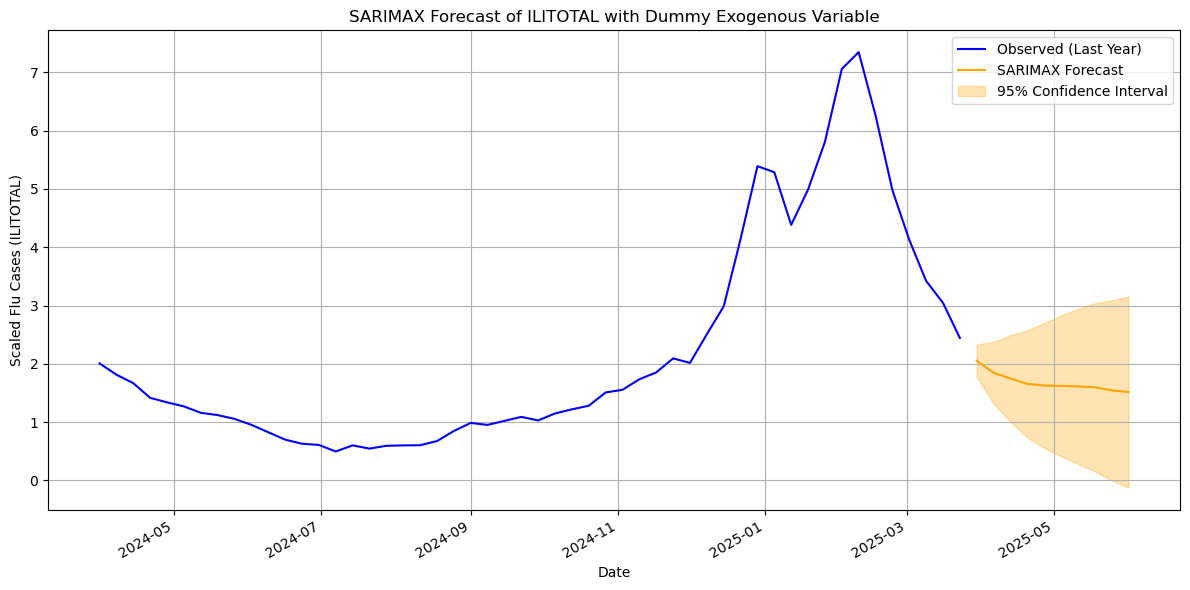

In [247]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df.index[-52:], df['ILITOTAL'].iloc[-52:], label='Observed (Last Year)', color='blue')
plt.plot(exog_future.index, forecast_mean, label='SARIMAX Forecast', color='orange')
plt.fill_between(
    exog_future.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval'
)
plt.title('SARIMAX Forecast of ILITOTAL with Dummy Exogenous Variable')
plt.xlabel('Date')
plt.ylabel('Scaled Flu Cases (ILITOTAL)')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

### SARIMAX Conclusions
The forecast very similar to a plain SARIMA model—because the constant exogenous variable doesn’t add any new predictive information. In other words, the model sees no variation in the exogenous regressor, so it behaves much like SARIMA would.

### MODEL 3: LINEAR REGRESSION MODEL

In [250]:
df = df.copy()
df['lag1'] = df['ILITOTAL'].shift(1)
df['lag2'] = df['ILITOTAL'].shift(2)

# Drop rows with NaN values (from shifting)
df_supervised = df.dropna()

In [252]:
# Features (lag values)
X = df_supervised[['lag1', 'lag2']]
# Target (current value)
y = df_supervised['ILITOTAL']

In [254]:
# Let's use 80% of the data for training and 20% for testing
split_index = int(len(df_supervised) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [258]:
# Train the LR model

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Test RMSE: 0.2862387997571997


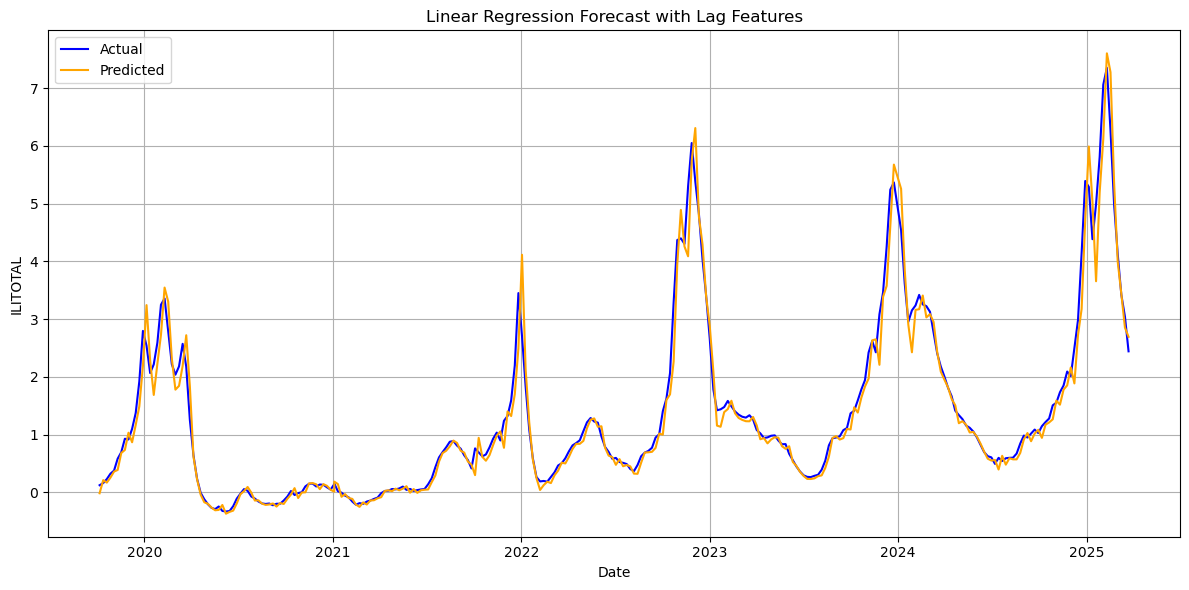

In [264]:
# Make predictions and plot
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Compute RMSE manually by taking the square root
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='orange')
plt.title('Linear Regression Forecast with Lag Features')
plt.xlabel('Date')
plt.ylabel('ILITOTAL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusion Linear Regression
- LR with lag features seems to be doing a good job at capturing the overall seasonal pattern of flu cases. The RMSE value of 0.286 is reasonably small, suggesting a good fitting model. 

In [266]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [268]:
print(rmse)
print(mae)

0.2862387997571997
0.16251829924709885
